In [1]:
from main import *
from cv2 import resize
from pywt import cwt
SHORT = True

In [2]:
if SHORT == True:
    machines = ["M01", "M02"]
    process_names = ["OP02","OP07"]
else:
    machines = ["M01", "M02","M03"]
    process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]

labels = ["good","bad"]
path_to_dataset = Path("./data/").absolute()


In [3]:
X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label, add_additional_label = True, verbose = False)
    #concatenating
    X_data.extend(data_list)
    y_data.extend(data_label)

In [4]:
X = [x.astype(np.float64) for x in X_data] # Ensure all examples have the same datatype
X = np.array([x[:4096, :3] for x in X]) # Select the first 4096 timesteps of all three dimensions for each row
y = np.array([0 if id.split("_")[-1] == "good" else 1 for id in y_data])

In [5]:
length = 4096
num_windows = 5

# Calculate the approximate size of each window
window_size = length // num_windows
remainder = length % num_windows

# Initialize the dictionary to store windows
windows = {}
start = 0

for i in range(1, num_windows + 1):
    # Calculate the end index for each window
    end = start + window_size + (1 if i <= remainder else 0)  # Distribute remainder
    windows[i] = (start, end - 1)
    start = end  # Update start for the next window



In [6]:
def cut_paste(X_train, p, b):
    """
    Apply CutPaste augmentation.
    
    Parameters:
    - X_train is a 3D array with shape (num_samples, num_timesteps, num_features)
    - p is the upper limit for sampling cut and paste windows
    - b is a dictionary or array containing window bounds for each index

    Returns:
    - CutPaste augmented X_train
    """
    num_samples, num_timesteps, num_sensors = X_train.shape

    X_aug = np.copy(X_train)
    
    for i, x in enumerate(X_aug):
        num_timesteps, num_features = x.shape

        # Step 2: Sample cut window
        W_c = np.random.randint(1, p + 1)
        b_lower_c, b_upper_c = b[W_c]

        # Step 3: Sample c1 and c2 within the bounds of the cut window
        c1 = np.random.randint(b_lower_c, b_upper_c + 1)
        c2 = np.random.randint(b_lower_c, b_upper_c + 1)

        # Step 6: Ensure c2 > c1
        if c1 > c2:
            c1, c2 = c2, c1

        # Step 7: Extract the snippet to cut (includes all features)
        cut_snippet = x[c1:c2, :]

        # Step 8: Define delta as the length of the snippet
        delta = c2 - c1

        # Step 9: Sample paste window
        W_j = np.random.randint(1, p + 1)
        while W_j == W_c: # Prevents cut window being the same as paste window
            W_j = np.random.randint(1, p + 1)
        b_lower_j, b_upper_j = b[W_j]

        # Step 10: Sample p1 and p2 within the bounds of the paste window minus delta
        p1 = np.random.randint(b_lower_j, b_upper_j - delta + 1)
        p2 = p1 + delta

        # Step 13: Paste the cut snippet into the new location in x (keeping all features)
        x[p1:p2, :] = cut_snippet

    return X_aug, c1, c2, p1, p2

In [7]:
def mean_shift(X_train, p, b):
    """
    Apply mean shift on multivariate time series data.

    Parameters:
    - X_train: numpy array of shape (num_samples, num_timesteps, num_sensors)
    - p: upper limit for window selection
    - b: dictionary with each Wj as key, and value being a tuple (b_lower, b_upper)

    Returns:
    - Shifted X_train with mean shift applied
    """
    num_samples, num_timesteps, num_sensors = X_train.shape

    X_aug = np.copy(X_train)
    
    for x in X_aug:
        # Step 2: Sample window W_j from U(1, p)
        W_j = np.random.randint(1, p + 1)
        
        # Step 3: Set window bounds based on b[W_j]
        b_lower, b_upper = b[W_j]
        
        # Step 3: Sample c1 and c2 within the bounds of the cut window
        c1 = np.random.randint(b_lower, b_upper + 1)
        c2 = np.random.randint(b_lower, b_upper + 1)

        # Step 6: Ensure c2 > c1
        if c1 > c2:
            c1, c2 = c2, c1
        
        # Step 7: Calculate time series mean across the window for each sensor
        time_series_mean = x[c1:c2].mean(axis=0)
        
        # Step 8: Apply mean shift
        x[c1:c2] = x[c1:c2] + time_series_mean
    
    return X_aug, c1, c2


In [8]:
def missing_signal(X_train, p, b):
    """
    Apply MissingSignal transformation on multivariate time series data.

    Parameters:
    - X_train: numpy array of shape (num_samples, num_timesteps, num_sensors)
    - p: upper limit for window selection
    - b: dictionary with each Wj as key, and value being a tuple (b_lower, b_upper)

    Returns:
    - Transformed X_train with missing signal applied
    """
    num_samples, num_timesteps, num_sensors = X_train.shape

    X_aug = np.copy(X_train)
    
    for x in X_aug:
        # Step 2: Sample window W_j from U(1, p)
        W_j = np.random.randint(1, p + 1)
        
        # Step 3: Set window bounds based on b[W_j]
        b_lower, b_upper = b[W_j]
        
        # Step 3: Sample c1 and c2 within the bounds of the cut window
        c1 = np.random.randint(b_lower, b_upper + 1)
        c2 = np.random.randint(b_lower, b_upper + 1)

        # Step 6: Ensure c2 > c1
        if c1 > c2:
            c1, c2 = c2, c1
        
        # Step 7: Set the constant to x[c1]
        constant = x[c1].copy()
        
        # Step 8: Replace values in the interval [c1, c2] with the constant
        x[c1:c2] = constant
    
    return X_aug, c1, c2


In [38]:
example = X[:3]
vlines = np.linspace(819, 4095, 5)

X_aug, c1, c2, p1, p2 = cut_paste(example, 5, windows)

exdf = pd.DataFrame(example[2])
augdf = pd.DataFrame(X_aug[2])

fig, ax = plt.subplots(3, 2, figsize = (15, 7))
for i in range(3):
    
    minex, maxex, minaug, maxaug = min(exdf[i]), max(exdf[i]), min(augdf[i]), max(augdf[i])
    ax[i, 0].plot(exdf[i])
    ax[i, 0].axvspan(c1, c2, ymin = 0.05, ymax = 0.85, color = "red", alpha = 0.3)
    ax[i, 0].vlines(vlines, minex, maxex, color = "black", alpha = 0.5)
    
    ax[i, 1].plot(augdf[i])
    ax[i, 1].axvspan(p1, p2, ymin = 0.05, ymax = 0.85, color = "red", alpha = 0.3)
    ax[i, 1].vlines(vlines, minaug, maxaug, color = "black", alpha = 0.5)

    paddingex = abs(maxex * 0.4)
    paddingaug = abs(maxaug * 0.4)
    ax[i, 0].set_ylim(top = maxex + paddingex)
    ax[i, 1].set_ylim(top = maxaug + paddingaug)
    
    for w, j in enumerate(vlines, 1):
        ax[i, 0].text((j - vlines[0] / 2), maxex + paddingex / 3, f"W{w}")
        ax[i, 1].text((j - vlines[0] / 2), maxaug + paddingaug / 3, f"W{w}")

fig.suptitle("CutPaste augmentation for X-, Y-, and Z-axis", y = 0.95)
#plt.savefig("plots/cutpaste.png")
plt.show()


ValueError: not enough values to unpack (expected 5, got 3)

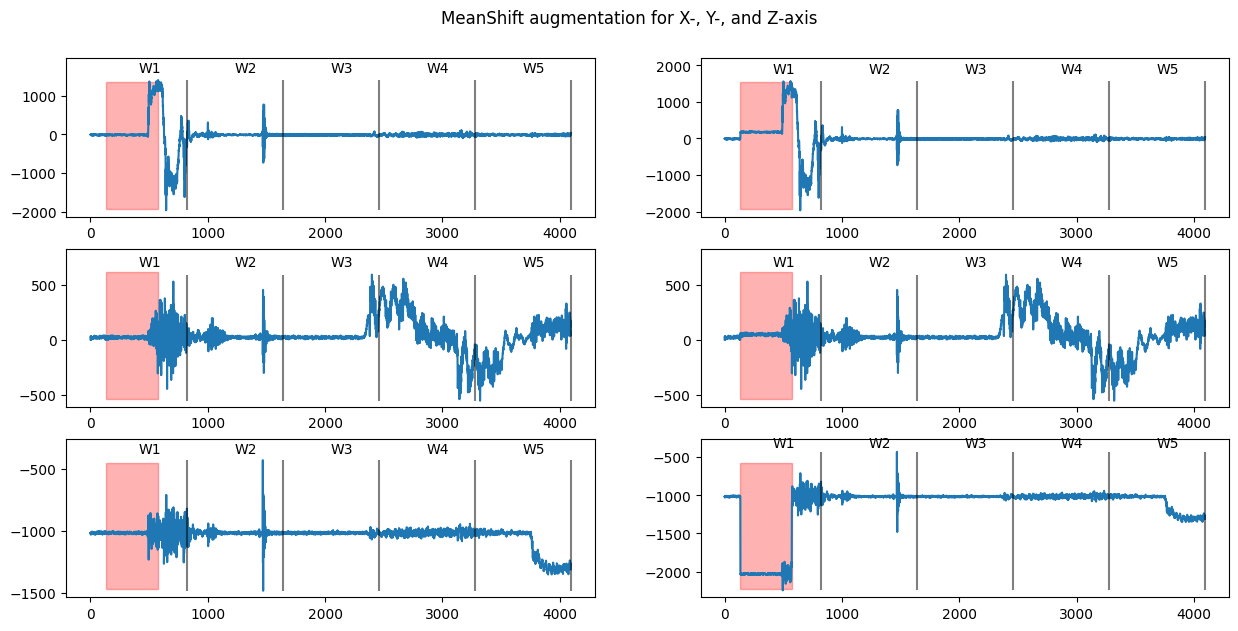

In [10]:
X_aug, c1, c2 = mean_shift(example, 5, windows)

exdf = pd.DataFrame(example[2])
augdf = pd.DataFrame(X_aug[2])

fig, ax = plt.subplots(3, 2, figsize = (15, 7))
for i in range(3):
    
    minex, maxex, minaug, maxaug = min(exdf[i]), max(exdf[i]), min(augdf[i]), max(augdf[i])
    ax[i, 0].plot(exdf[i])
    ax[i, 0].axvspan(c1, c2, ymin = 0.05, ymax = 0.85, color = "red", alpha = 0.3)
    ax[i, 0].vlines(vlines, minex, maxex, color = "black", alpha = 0.5)
    
    ax[i, 1].plot(augdf[i])
    ax[i, 1].axvspan(c1, c2, ymin = 0.05, ymax = 0.85, color = "red", alpha = 0.3)
    ax[i, 1].vlines(vlines, minaug, maxaug, color = "black", alpha = 0.5)

    paddingex = abs(maxex * 0.4)
    paddingaug = abs(maxaug * 0.4)
    ax[i, 0].set_ylim(top = maxex + paddingex)
    ax[i, 1].set_ylim(top = maxaug + paddingaug)
    for w, j in enumerate(vlines, 1):
        ax[i, 0].text((j - vlines[0] / 2), maxex + paddingex / 3, f"W{w}")
        ax[i, 1].text((j - vlines[0] / 2), maxaug + paddingaug / 3, f"W{w}")

fig.suptitle("MeanShift augmentation for X-, Y-, and Z-axis", y = 0.95)
#plt.savefig("plots/meanshift.png")
plt.show()

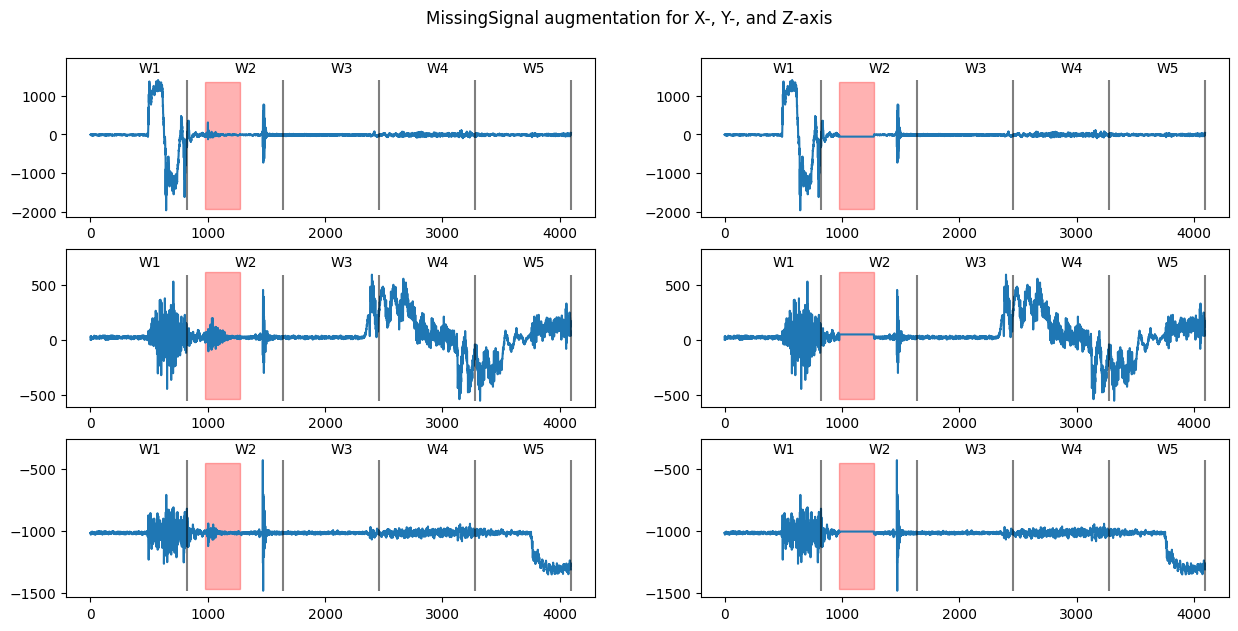

In [11]:
X_aug, c1, c2 = missing_signal(example, 5, windows)

exdf = pd.DataFrame(example[2])
augdf = pd.DataFrame(X_aug[2])

fig, ax = plt.subplots(3, 2, figsize = (15, 7))
for i in range(3):
    
    minex, maxex, minaug, maxaug = min(exdf[i]), max(exdf[i]), min(augdf[i]), max(augdf[i])
    ax[i, 0].plot(exdf[i])
    ax[i, 0].axvspan(c1, c2, ymin = 0.05, ymax = 0.85, color = "red", alpha = 0.3)
    ax[i, 0].vlines(vlines, minex, maxex, color = "black", alpha = 0.5)
    
    ax[i, 1].plot(augdf[i])
    ax[i, 1].axvspan(c1, c2, ymin = 0.05, ymax = 0.85, color = "red", alpha = 0.3)
    ax[i, 1].vlines(vlines, minaug, maxaug, color = "black", alpha = 0.5)

    paddingex = abs(maxex * 0.4)
    paddingaug = abs(maxaug * 0.4)
    ax[i, 0].set_ylim(top = maxex + paddingex)
    ax[i, 1].set_ylim(top = maxaug + paddingaug)
    for w, j in enumerate(vlines, 1):
        ax[i, 0].text((j - vlines[0] / 2), maxex + paddingex / 3, f"W{w}")
        ax[i, 1].text((j - vlines[0] / 2), maxaug + paddingaug / 3, f"W{w}")

fig.suptitle("MissingSignal augmentation for X-, Y-, and Z-axis", y = 0.95)
#plt.savefig("plots/missingsignal.png")
plt.show()